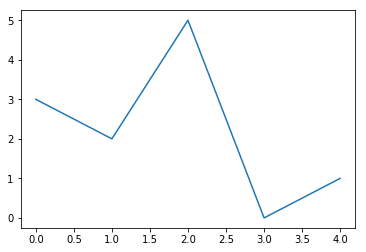

In [1]:
import matplotlib.pyplot as plt
import numpy as np

vals = [3,2,5,0,1]
plt.plot(vals)
plt.show()

In [2]:
counts = {}

for line in open("radishsurvey.txt"):
    line = line.strip()
    name, vote = line.split(" - ")
    if vote not in counts:
        # First vote for this variety
        counts[vote] = 1
    else:
        # Increment the vote count
        counts[vote] = counts[vote] + 1
print(counts)


{'white icicle': 5, 'Snow Belle': 58, 'sicily giant': 3, 'April Cross': 67, 'Plum  Purple': 1, 'snow belle': 3, ' Plum Purple': 1, 'April cross': 1, 'Sicily  Giant': 1, ' Snow Belle': 2, 'Champion': 75, 'Cherry Belle': 53, ' Daikon': 1, 'Bunny Tail': 68, 'bunny tail': 4, 'Red King': 52, 'french breakfast': 7, 'plum purple': 1, 'White Icicle': 59, 'champion': 1, 'cherry belle': 2, 'Daikon': 58, 'Sicily Giant': 52, ' plum purple': 1, 'april cross': 4, ' Red King': 1, 'red king': 3, ' White Icicle': 1, ' Cherry Belle': 2, 'daikon': 4, 'Cherry  Belle': 1, ' Sicily Giant': 1, 'French Breakfast': 65, 'Plum Purple': 53}


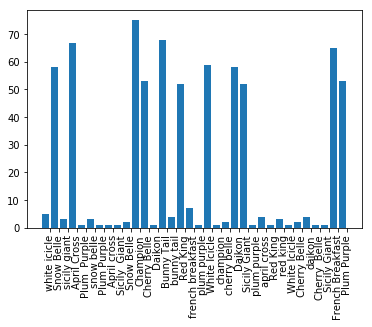

In [3]:
names = []
votes = []

for radish in counts:
    names.append(radish)
    votes.append(counts[radish])
    
x = np.arange(len(counts))

plt.bar(x, votes)
plt.xticks(x + 0.5, names, rotation=90)
plt.show()

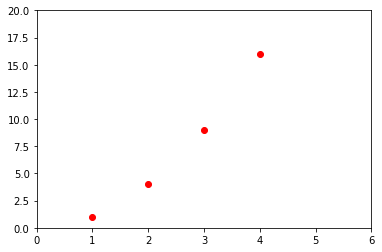

In [4]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4], [1,4,9,16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()

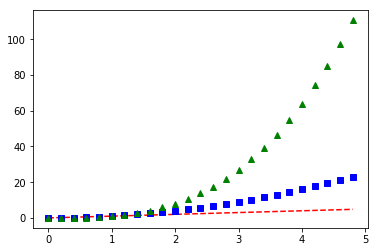

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

from model.Base import Base
from model.Device import Device
from model.DeviceAppTraffic import DeviceAppTraffic
from model.DnsReq import DnsReq
from model.Flow import Flow
from model.User import User
from model.user_devices import user_devices

from sqlalchemy import create_engine, text, func
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import NullPool

import datautils
import datetime

from IPython.display import display

#output_notebook()

def main():
    DB='postgresql+psycopg2:///ucnstudy'

    engine = create_engine(DB, echo=False, poolclass=NullPool)
    Base.metadata.bind = engine
    Session = sessionmaker(bind=engine)
    ses = Session()
    print('lala')

    devices = ses.query(Device).distinct().order_by(Device.id)

    for dev in devices:

        sql_end_day = text("SELECT distinct devid, flows.endts FROM flows join (SELECT DATE(endts) as date_entered, MAX(endts) as max_time\
 FROM flows WHERE devid =:d_id GROUP BY date(endts)) AS grp ON grp.max_time = flows.endts order by flows.endts;").bindparams(d_id = dev.id\
)
        result_end_day = ses.execute(sql_end_day)

        info = defaultdict(list)
        for row in result_end_day:
            info['devid'].append(str(row[0]))
            info['end'].append(row[1])

        sql_beg_day = text("SELECT distinct devid, flows.startts FROM flows join (SELECT DATE(startts) as date_entered, MIN(startts) as mi\
n_time FROM flows WHERE devid =:d_id and extract (hour from startts) > 3 GROUP BY date(startts)) AS grp ON grp.min_time = flows.startts or\
der by flows.startts;").bindparams(d_id = dev.id)
        
        sql_startts = text("select devid, startts from flows where devid = :d_id order by startts").bindparams(d_id = dev.id)
        result_beg_day = ses.execute(sql_beg_day)
        result_startts = ses.execute(sql_startts)

        for row in result_beg_day:
            info['start'].append(row[1])

        #add days that only have value before 3 am
        for row in result_startts:
            timst = row[1]
            in_list = False
            for date in info['start']:
                if date.day == timst.day and date.month == timst.month and date.year == timst.year:
                    in_list = True
            if in_list == False:
                info['start'].append(timst)

        info['start'].sort()
        df = pd.DataFrame(info)
        display(df)

        print('la')
        #create table with times for each week day
        #info['start'].sort()
        info_week = defaultdict(list)
        if (info['start']):
            for timst in info['start']:
                day = timst
                weekday = day.strftime('%A')
                key = weekday + ' start'
                info_week[key].append(day)
                #print(day, day.strftime('%A'))

            for timst in info['end']:
                day = timst
                weekday = day.strftime('%A')
                key = weekday + ' end'
                info_week[key].append(day)

        days_str = {'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'}
        for name in days_str:
            df_col = defaultdict(list)
            df_col['device'] = str(dev.id)
            df_col[name+' beg'] = info_week[name+' start']
            df_col[name+' end'] = info_week[name+' end']
            #print(df_col[name+' beg'])
            #print(df_col[name+' end'])
            df_week = pd.DataFrame(df_col)
            #df_week.columns = [name+' start', name + ' end']
            display(df_week)